In [1]:
%matplotlib notebook

from cr3bp.lagrange import EARTH_MOON, opt_lag_points, partial_acc_rot, partial_acc_rot_dim, un_rotate
from cr3bp.lagrange import dSdt_rot, dSdt_rot_dim, dSdt_inert_3body


#from cr3bp.lagrange import dSdt_dimensionless, theoretical_lag_points, EARTH_MOON, dSdt
#from cr3bp.lagrange import adjusted_lag_points, partial_acc_dimensionless, partial_acc
#from cr3bp.lagrange import EARTH_MOON, theoretical_lag_points, optimized_lag_points, dSdt, dSdt_dimensional,dSdt_three_bodies_nondimensional
#from cr3bp.lagrange import partial_acc, partial_acc_dimensional, G, dSdt_nonrotating, dSdt_three_bodies_3d, propagate_orbit, un_rotate
import numpy as np
from scipy import optimize # Using Newton-Ramson method   
from functools import partial
from numpy.linalg import norm
from scipy.integrate import solve_ivp 
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Initial value problem
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

In [2]:
def polynomial(a0, a1, a2, a3 ,a4 , x):
    return a0 + x*(a1+x*(a2+x*(a3+x*a4)))

In [3]:
# These are series for calculating the lagrange points. Even though the accelearation in a rotating reference frame is not 0
# This is defined in a paper called T_Munch.pdf
b=EARTH_MOON['m2']/EARTH_MOON['m1']
a= np.cbrt(EARTH_MOON['m2']/(3*EARTH_MOON['m1']))
x_L1 = polynomial(EARTH_MOON['m1']/(EARTH_MOON['m1']+EARTH_MOON['m2']),-1,1/3,1/9,23/81,a)
x_L2 = polynomial(EARTH_MOON['m1']/(EARTH_MOON['m1']+EARTH_MOON['m2']),1,1/3,-1/9,-31/81,a)
x_L3 = polynomial(EARTH_MOON['m1']/(EARTH_MOON['m1']+EARTH_MOON['m2'])-2,7/12,-7/12,13223/20736,0,b)
L1_st0 = np.array([x_L1, 0,0,0,0,0])
L2_st0 = np.array([x_L2, 0,0,0,0,0])
L3_st0 = np.array([x_L3, 0,0,0,0,0])
st0 = [L1_st0, L2_st0, L3_st0 ]
for st in st0 :
    print (f'Lagrange Point : [{st[0]}, {st[1]}, {st[2]}]')
    acc = partial_acc_rot(st, EARTH_MOON["alpha"])[3:6]
    print (f'Acceleration at Lagrange point is: [{acc[0]}, {acc[1]}, {acc[2]}]')

Lagrange Point : [0.8369628808702578, 0.0, 0.0]
Acceleration at Lagrange point is: [0.0007104930057107994, -0.0, -0.0]
Lagrange Point : [1.155745693659817, 0.0, 0.0]
Acceleration at Lagrange point is: [0.0003815123510666485, -0.0, -0.0]
Lagrange Point : [-1.0050639103081698, 0.0, 0.0]
Acceleration at Lagrange point is: [4.879940786401207e-08, -0.0, 0.0]


In [4]:
# For dimension-less Earth-Moon system (with the magnitudes normalized). The acceleration in the rotating referenceframe is pretty close to 0
lag_points = opt_lag_points(partial_acc_rot, EARTH_MOON['alpha'])

L1: th:[0.8405852136095322,0.0], opt:[0.8369000024423547,0.0] where acc=2.220446049250313e-16
L2: th:[1.1594147863904678,0.0], opt:[1.155693986126838,0.0] where acc=9.992007221626409e-16
L3: th:[-1.0050640247279399,0.0], opt:[-1.0050639264594907,0.0] where acc=1.2706849461530112e-16
L4: th:[0.48784634065294424,0.8660254037844386], opt:[0.4878463406529436,0.8660254037844386] where acc=1.2718744215706504e-15
L5: th:[0.48784634065294424,-0.8660254037844386], opt:[0.4878463406529436,-0.8660254037844386] where acc=1.2718744215706504e-15


In [5]:
# For dimensional (with normal units, Km, Kg and secs) Earth-Moon system 
dlag_points = opt_lag_points(partial_acc_rot_dim, EARTH_MOON['alpha'], r=EARTH_MOON['l_star'])

L1: th:[323120.9561115042,0.0], opt:[321544.598979495,0.0] where acc=1.9058241313221758e-21
L2: th:[445679.0438884958,0.0], opt:[444147.623217434,0.0] where acc=1.4823076576950256e-21
L3: th:[-386346.6111054201,0.0], opt:[-386682.12311316974,0.0] where acc=3.044024654195142e-22
L4: th:[187528.13334699176,332900.16521473817], opt:[188243.58465706662,332900.16521473817] where acc=2.680722325812825e-10
L5: th:[187528.13334699176,-332900.16521473817], opt:[188243.58465706662,-332900.16521473817] where acc=2.680722325812825e-10


In [6]:
# The Lagrange points calculated with dimension-less equation (the positions are divided by R) but multiplied by R. The result 
# does not match with the ones obtained with the dimensional equation
R=EARTH_MOON['l_star']
for idx, point in enumerate(lag_points):
    dp = dlag_points[idx]
    rp = R*point
    diff = dlag_points[idx] - R*point
    print (f'Dimension: [{dp[0]}, {dp[1]}, {dp[2]}]  *R: [{rp[0]}, {rp[1]}, {rp[2]}]  Diff (Km): [{diff[0]}, {diff[1]}, {diff[2]}]')

Dimension: [321544.598979495, 0.0, 0.0]  *R: [321704.3609388412, 0.0, 0.0]  Diff (Km): [-159.7619593461859, 0.0, 0.0]
Dimension: [444147.623217434, 0.0, 0.0]  *R: [444248.76826715656, 0.0, 0.0]  Diff (Km): [-101.14504972257419, 0.0, 0.0]
Dimension: [-386682.12311316974, 0.0, 0.0]  *R: [-386346.5733310282, 0.0, 0.0]  Diff (Km): [-335.54978214151924, 0.0, 0.0]
Dimension: [188243.58465706662, 332900.16521473817, 0.0]  *R: [187528.1333469915, 332900.16521473817, 0.0]  Diff (Km): [715.451310075121, 0.0, 0.0]
Dimension: [188243.58465706662, -332900.16521473817, 0.0]  *R: [187528.1333469915, -332900.16521473817, 0.0]  Diff (Km): [715.451310075121, 0.0, 0.0]


#### Because in the inertial frame of reference we need also to provide the initial velocities (that are not obvious), first we solve the problem in the rotating frame of reference (that is easier) and calcute the initial conditions so we can solve the problem in the inertial frame of reference.

### Rotating reference frame (dimension-less)

In [7]:
# Earth-Moon system. This is just for curiosity
MOON_ROTATION_PERIOD_IN_SECS=27*24*3600+7*3600+43*60+11.5
MOON_ROTATION_PERIOD_IN_DAYS=MOON_ROTATION_PERIOD_IN_SECS/24/3600
MOON_ROTATION_PERIOD_IN_YEARS=MOON_ROTATION_PERIOD_IN_SECS/(365*24*3600)
one_day = 2*np.pi/MOON_ROTATION_PERIOD_IN_DAYS
one_hour = one_day/24
# The time unit chosen is the one in which w=1 rad/tu (tu: time unit) so to cover 2*PI radians (1 period), it takes 2 PI time units
# So, the time unit is the period divided by 2 PI. The time unit for the EARTH MOON system is EARTH_MOON['t_star']=1.1888906e-2 #years
# so the moon rotation period in years is:
MOON_ROTATION_PERIOD_IN_YEARS=EARTH_MOON['t_star']*2*np.pi
# On the other hand, we have the moon rotation in secs:
MOON_ROTATION_PERIOD_IN_SECS=27*24*3600+7*3600+43*60+11.5
# So we can calculate how many days or seconds are considered in one year according to the values for t_star
SECONDS_IN_ONE_YEAR = MOON_ROTATION_PERIOD_IN_SECS/MOON_ROTATION_PERIOD_IN_YEARS
DAYS_IN_ONE_YEAR=SECONDS_IN_ONE_YEAR/24/3600
# The value obtained is 365.7508422115136 (I would expect 365.25)

In [8]:
# We get the optimized lag points for the dimension-less case
lag_points = opt_lag_points(partial_acc_rot, EARTH_MOON['alpha'], traces=False)
lag_st0 =[np.concatenate((L, np.zeros(3))) for L in lag_points]
alpha = EARTH_MOON['alpha']
# With n_periods=3, the lagrange points are stable. However, with more simulation time, L1, L2 and L3 starts to diverge.
# L4 and L5 are more stable.
N_PERIODS = 5
t0 = 0 
tf = 2*np.pi*N_PERIODS
n_steps = 1000  #number of evaluation points
ts = np.linspace(0.0, tf, n_steps+1)
sols = []
for idx, S0 in enumerate(lag_st0):
    sols.append(solve_ivp(dSdt_rot, (t0, tf), S0, args=(alpha,), method='LSODA', rtol= 1e-13, t_eval=ts, dense_output=False))
    print (f'The number of time samples for L{idx+1} is {len(sols[idx].t)}')

# The solution is 3d (x,y,z) coordinates but just constain positions and velocities of m3
r1_xyz_rot_ts = np.tile(np.array([-alpha ,0, 0]), (n_steps+1,1))  # The fixed position of m1 is replicated at all time points
r2_xyz_rot_ts = np.tile(np.array([1-alpha,0, 0]), (n_steps+1,1))  # The fixed position of m1 is replicated at all time points
print ("Shape of r1_xyz_rot_ts: ",r1_xyz_rot_ts.shape)
print ("Shape of r2_xyz_rot_ts: ",r2_xyz_rot_ts.shape)
print ("Shape of r3_xyz_rot_ts (L1): ",sols[0].y[0:3].T.shape)

The number of time samples for L1 is 1001
The number of time samples for L2 is 1001
The number of time samples for L3 is 1001
The number of time samples for L4 is 1001
The number of time samples for L5 is 1001
Shape of r1_xyz_rot_ts:  (1001, 3)
Shape of r2_xyz_rot_ts:  (1001, 3)
Shape of r3_xyz_rot_ts (L1):  (1001, 3)


In [9]:
# For calculating the inital velocity for the inertial reference frame, it is easier to calculate them in the rotating reference frame
w_xyz = np.array([0,0,1]) # The angular velocity of the dimension-less frame of reference.
# Because, all the solutions are evaluated in the same time samples (ts), we For the time values, because all solutions are evaluated in the same times (t_eval) we take that

# The position of m1 at rotating frame of reference is unrotated (i.e. we move from rotating reference frame to the inertial
# reference frame) for the first time sample, i.e., the initial position of m1 in the inertial reference frame
r1_xyz_t0 = un_rotate(r1_xyz_rot_ts, ts)[0,:] 
# The velocity seen from the inertial reference frame is calculated with w x r (by definition)
v1_xyz_t0 = np.cross(w_xyz, r1_xyz_t0)
print (f'For m1 at t0: r: [{r1_xyz_t0[0]},{r1_xyz_t0[1]},{0}] v: [{v1_xyz_t0[0]},{v1_xyz_t0[1]},{0}]')

# For m2
r2_xyz_t0 = un_rotate(r2_xyz_rot_ts, ts)[0,:]
v2_xyz_t0 = np.cross(w_xyz, r2_xyz_t0)
print (f'For m2 at t0: r: [{r2_xyz_t0[0]},{r2_xyz_t0[1]},{0}] v: [{v2_xyz_t0[0]},{v2_xyz_t0[1]},{0}]')

# For m3
for idx in range(0,5):
    r3_xyz_t0 = un_rotate(sols[idx].y[0:2,:].T, ts)[0,:]
    v3_xyz_t0 = np.cross(w_xyz, r3_xyz_t0)
    print (f'For m3 at t0 for L{idx+1}: r: [{r3_xyz_t0[0]},{r3_xyz_t0[1]},{0}] v: [{v3_xyz_t0[0]},{v3_xyz_t0[1]},{0}]')

For m1 at t0: r: [-0.012153659347055779,0.0,0] v: [0.0,-0.012153659347055779,0]
For m2 at t0: r: [0.9878463406529442,0.0,0] v: [0.0,0.9878463406529442,0]
For m3 at t0 for L1: r: [0.8369000024423547,0.0,0] v: [-0.0,0.8369000024423547,0]
For m3 at t0 for L2: r: [1.155693986126838,0.0,0] v: [-0.0,1.155693986126838,0]
For m3 at t0 for L3: r: [-1.0050639264594907,0.0,0] v: [-0.0,-1.0050639264594907,0]
For m3 at t0 for L4: r: [0.4878463406529436,0.8660254037844386,0] v: [-0.8660254037844386,0.4878463406529436,0]
For m3 at t0 for L5: r: [0.4878463406529436,-0.8660254037844386,0] v: [0.8660254037844386,0.4878463406529436,0]


### Three bodies from a inertial frame of reference (dimension-less)

In [18]:
# For the inertial frame of reference (Earth-Moon system) we need the initial conditions for m1, m2, m3
# The ones that we have previously calculated.
R = EARTH_MOON['l_star']
alpha = EARTH_MOON['alpha']
M = EARTH_MOON['m1'] + EARTH_MOON['m2'] 
m1_norm = EARTH_MOON['m1']/M  # m1 dimension-less
m2_norm = EARTH_MOON['m2']/M  # m2 dimension-less

r1 = np.array([-0.012153659347055779,0.0,0])     # r0 for Earth m1 
v1 = np.array([-0.0,-0.012153659347055779,0])    # v0 for Earth m1

r2 = np.array([0.9878463406529442,0.0,0])     # r0 for Moon m2
v2 = np.array([-0.0,0.9878463406529442,0])    # v0 for Moon m2

#For m1 at t0: r: [-0.012153659347055779,0.0,0] v: [0.0,-0.012153659347055779,0]
#For m2 at t0: r: [0.9878463406529442,0.0,0] v: [0.0,0.9878463406529442,0]
#For m3 at t0 for L1: r: [0.8369000024423547,0.0,0] v: [-0.0,0.8369000024423547,0]
#For m3 at t0 for L2: r: [1.155693986126838,0.0,0] v: [-0.0,1.155693986126838,0]
#For m3 at t0 for L3: r: [-1.0050639264594907,0.0,0] v: [-0.0,-1.0050639264594907,0]
#For m3 at t0 for L4: r: [0.4878463406529436,0.8660254037844386,0] v: [-0.8660254037844386,0.4878463406529436,0]
#For m3 at t0 for L5: r: [0.4878463406529436,-0.8660254037844386,0] v: [0.8660254037844386,0.4878463406529436,0]

m3_st0 =[]
m3_st0.append(np.array([0.8369000024423547,0.0,0,0.0,0.8369000024423547,0]))
m3_st0.append(np.array([1.155693986126838,0.0,0,0.0,1.155693986126838,0]))
m3_st0.append(np.array([-1.0050639264594907,0.0,0, 0.0,-1.0050639264594907,0]))
m3_st0.append(np.array([0.4878463406529436,0.8660254037844386,0,-0.8660254037844386,0.4878463406529436,0]))
m3_st0.append(np.array([0.4878463406529436,-0.8660254037844386,0, 0.8660254037844386,0.4878463406529436,0]))

N_PERIODS = 3
t0 = 0 
tf = 2*np.pi*N_PERIODS
n_steps = 1000  #number of evaluation points
ts = np.linspace(0.0, tf, n_steps+1)
sols_st = []
for idx, m3_st0 in enumerate(m3_st0):
    S0 = np.concatenate((r1, v1, r2, v2, m3_st0[0:3], m3_st0[3:6]))
    sol = solve_ivp(dSdt_inert_3body, (t0, tf), S0, args=(m1_norm,m2_norm), method='LSODA', rtol= 1e-13, t_eval=ts, dense_output=False)    
    st = {}
    st['m1'] = sol.y[:6,:].T
    st['m2'] = sol.y[6:12,:].T
    st['m3'] = sol.y[12:18,:].T
    sols_st.append(st)

<IPython.core.display.Javascript object>


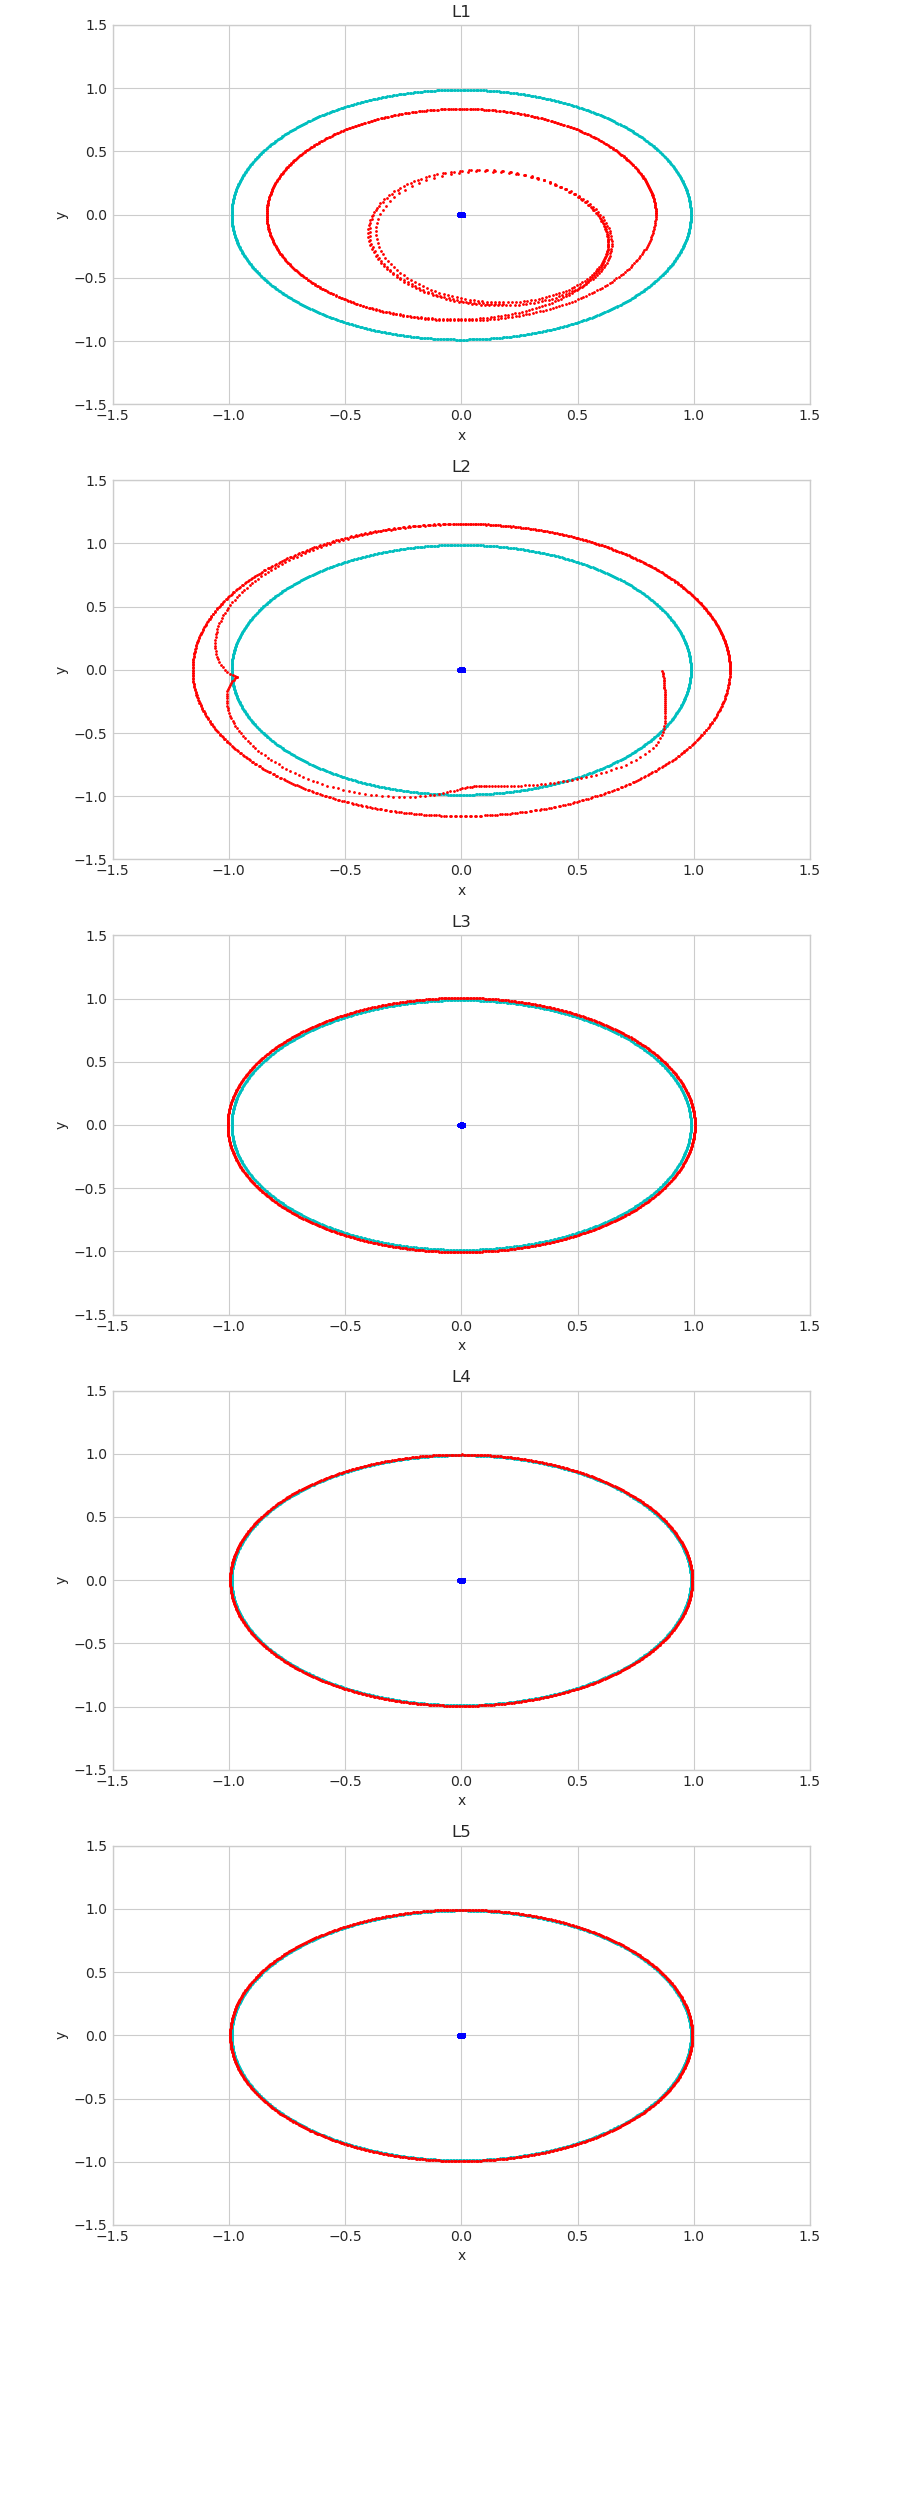

In [26]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=len(sols_st),figsize=(9,5*5))
fig.subplots_adjust(hspace=0.2,top=0.99)
colors= ['bo','co','ro']
for idx, sol in enumerate(sols_st) :
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel('y')
    limit=1.5
    x_limits = (-limit,limit)
    y_limits = (-limit,limit)
    ax[idx].set_xlim(x_limits)
    ax[idx].set_ylim(y_limits)
    count = 0
    for idx, (body_name, st) in enumerate(sol.items()):
        ax[idx].plot(st[:,0:1], st[:,1:2] , colors[count], ms = 1 )
        count += 1   
    ax[idx].set_title("L"+str(idx+1))


### Inertial reference frame (dimensional)

In [117]:
# Three bodys (Earth Moon system) from a reference frame non-rotating
# In this case, the velocity of the m3 (massless particle) is the key
# To calculate the initial velocity, I have solved in the rotating frame of reference and once
# I have the positions, I can calculate the velocity in the non-rotating frame of reference doing w x r
R = EARTH_MOON['l_star']
m1 = EARTH_MOON['m1']
m2 = EARTH_MOON['m2']
m3 = 1
x1 = R*EARTH_MOON['m2']/(EARTH_MOON['m2']+EARTH_MOON['m1'])
x2 = R*EARTH_MOON['m1']/(EARTH_MOON['m2']+EARTH_MOON['m1'])
r1 = np.array([-x1,0,0])     # Earth m1 
v1 = np.array([0,0,0])
r2 = np.array([x2,0,0])      # Moon  m2
v2 = np.array([0,1,0])
r3 = dlag_points[0]          # m3 a L2
r3 = np.array([321704.3609388412,0.0,0]) 
r3 = np.array([444248.76826715656,0.0,0])
#v3 = np.array([-0.0,0.8562803491864328,0.0]) # for L1
v3 = np.array([-0.0,1.182456741672088,0.0]) # for L2
#v3 = np.array([-0.0,-1.0283384961068855,0.0]) # for L3
#v3 = np.array([-0.8860802162656688,0.49914354606827616,0.0]) # for L4
#v3 = np.array([0.8860802162656688,0.49914354606827616,-0.0]) # for L5

t0 = 0  #sec
tf = 27.3 * 24 * 3600 #  1 month
n_steps = 1000  #number of evaluation points
dt = tf/n_steps
T = np.linspace(0.0, tf, n_steps+1)
S0 = np.concatenate((r1, r2, r3, v1, v2, v3))

sol = solve_ivp(dSdt_three_bodies_3d, (t0, tf), S0, args=(G,m1,m2,m3), t_eval=T, rtol = 1e-13)   
orbs={}
orbs['m1'] = sol.y[:3,:].T
orbs['m2'] = sol.y[3:6,:].T
orbs['m3'] = sol.y[6:9,:].T
orbs['G'] =  (m1*orbs['m1']+m2*orbs['m2']+m3*orbs['m3'])/(m1+m2+m3)

#With respect G
orbs['m1'] =  orbs['m1']  - orbs['G']
orbs['m2'] =  orbs['m2']  - orbs['G'] 
orbs['m3'] =  orbs['m3']  - orbs['G'] 
_= orbs.pop('G')

In [118]:
# The z axis is removed for ploting 2D
orbs['m1'] = orbs['m1'][:,:2]
orbs['m2'] = orbs['m2'][:,:2]
orbs['m3'] = orbs['m3'][:,:2]

<IPython.core.display.Javascript object>


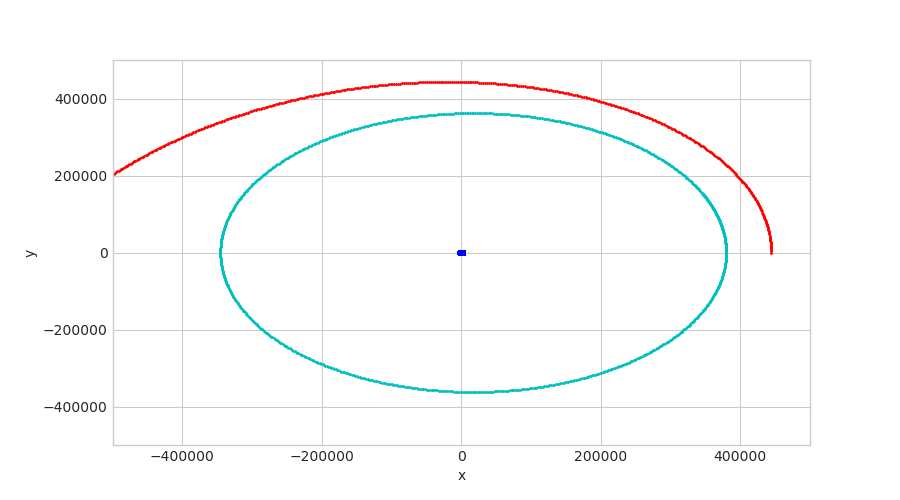

In [119]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=1,figsize=(9,5))
ax.set_xlabel('x')
ax.set_ylabel('y')
limit=500000
x_limits = (-limit,limit)
y_limits = (-limit,limit)
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
#ax.plot(-alpha ,    0, 'mo', ms = 10 )
#ax.plot( 1 - alpha, 0, 'co', ms = 5  )
ax.plot(orbs['m1'][:,0], orbs['m1'][:,1],'bo', ms=1)
ax.plot(orbs['m2'][:,0], orbs['m2'][:,1],'co', ms=1)
ax.plot(orbs['m3'][:,0], orbs['m3'][:,1],'ro', ms=1)

### Rotating reference frame (dimension-less)

In [26]:
# Earth-Moon system
MOON_ROTATION_PERIOD_IN_SECS=27*24*3600+7*3600+43*60+11.5
MOON_ROTATION_PERIOD_IN_DAYS=MOON_ROTATION_PERIOD_IN_SECS/24/3600
MOON_ROTATION_PERIOD_IN_YEARS=MOON_ROTATION_PERIOD_IN_SECS/(365*24*3600)
one_day = 2*np.pi/MOON_ROTATION_PERIOD_IN_DAYS
one_hour = one_day/24
# The time unit chooses is the one that w=1 rad/tu (tu: time unit) so to cover 2 PI radians (1 period), it takes 2 PI time unit
# The time unit is the period divided by 2 PI. The time unit for the EARTH MOON system is EARTH_MOON['t_star']=1.1888906e-2 #years
# so the moon rotation period in years is:
MOON_ROTATION_PERIOD_IN_YEARS=EARTH_MOON['t_star']*2*np.pi
# On the other hand, we have the moon rotation in secs:
MOON_ROTATION_PERIOD_IN_SECS=27*24*3600+7*3600+43*60+11.5
# So we can calculate how many days or seconds are considered in one year according to the values for t_star
SECONDS_IN_ONE_YEAR = MOON_ROTATION_PERIOD_IN_SECS/MOON_ROTATION_PERIOD_IN_YEARS
DAYS_IN_ONE_YEAR=SECONDS_IN_ONE_YEAR/24/3600
# The value obtained is 365.7508422115136 (I would expect 365.25)

In [27]:
#https://numpy.org/doc/stable/reference/generated/numpy.arange.html#numpy.arange
lagrange_st0 =[np.concatenate((L, np.zeros(3))) for L in lag_points]
alpha = EARTH_MOON['alpha']
# With n_periods=3, the lagrange points are stable. However, with more simulation time, L1, L2 and L3 starts to diverge.
# L4 and L5 are more stable.
n_periods = 5
t0 = 0 
tf = 2*np.pi*n_periods
n_steps = 1000  #number of evaluation points
t_eval = np.linspace(0.0, tf, n_steps+1)
#t_eval = None
sols = []
for idx, S0 in enumerate(lagrange_st0):
    sols.append(solve_ivp(dSdt, (t0, tf), S0, args=(alpha,), method='LSODA', rtol= 1e-10, t_eval=t_eval, dense_output=False))
    # len(sols[idx].t) is the number of samples 
    print (len(sols[idx].t))

# sols 2d (x,y) coordinates and just for the coordinates of m3

#sols = propagate_orbit(0, alpha, lagrange_st0, tspans, dSdt, t_eval)
# The solution is 2d (x,y) coordinates but it only contains the coordinates of m3
r1_xyz_rot_ts = np.tile(np.array([-alpha ,0]), (n_steps+1,1))
r2_xyz_rot_ts = np.tile(np.array([1-alpha ,0]), (n_steps+1,1))
print ("Shape of r1_xyz_rot_ts: ",r1_xyz_rot_ts.shape)
print ("Shape of r2_xyz_rot_ts: ",r2_xyz_rot_ts.shape)
print ("Shape of r3_xyz_rot_ts (first solution): ",sols[0].y[0:2].T.shape)


1001
1001
1001
1001
1001
Shape of r1_xyz_rot_ts:  (1001, 2)
Shape of r2_xyz_rot_ts:  (1001, 2)
Shape of r3_xyz_rot_ts (first solution):  (1001, 2)


In [28]:
# For calculating the inital velocity for the inertial, it is easier to calculate in the rotating reference frame
w_xyz = np.array([0,0,1]) # The rotation velocity 
# For the time values, because all solutions are evaluated in the same times (t_eval) we take that
# For m1
r1_xyz_t0 = un_rotate(r1_xyz_rot_ts, t_eval)[0,:]
v1_xyz_t0 = np.cross(w_xyz, r1_xyz_t0)
print (f'For m1: r: [{r1_xyz_t0[0]},{r1_xyz_t0[1]},{0}] v: [{v1_xyz_t0[0]},{v1_xyz_t0[1]},{0}]')
# For m2
r2_xyz_t0 = un_rotate(r2_xyz_rot_ts, t_eval)[0,:]
v2_xyz_t0 = np.cross(w_xyz, r2_xyz_t0)
print (f'For m2: r: [{r2_xyz_t0[0]},{r2_xyz_t0[1]},{0}] v: [{v2_xyz_t0[0]},{v2_xyz_t0[1]},{0}]')
# For m3
for idx in range(0,5):
    r3_xyz_t0 = un_rotate(sols[idx].y[0:2,:].T, t_eval)[0,:]
    v3_xyz_t0 = np.cross(w_xyz, r3_xyz_t0)
    print (f'For m3 at L{idx+1}: r: [{r3_xyz_t0[0]},{r3_xyz_t0[1]},{0}] v: [{v3_xyz_t0[0]},{v3_xyz_t0[1]},{0}]')


For m1: r: [-0.012153659347055779,0.0,0] v: [-0.0,-0.012153659347055779,0]
For m2: r: [0.9878463406529442,0.0,0] v: [-0.0,0.9878463406529442,0]
For m3 at L1: r: [0.8369000024423547,0.0,0] v: [-0.0,0.8369000024423547,0]
For m3 at L2: r: [1.155693986126838,0.0,0] v: [-0.0,1.155693986126838,0]
For m3 at L3: r: [-1.0050639264594907,0.0,0] v: [-0.0,-1.0050639264594907,0]
For m3 at L4: r: [0.4878463406529436,0.8660254037844386,0] v: [-0.8660254037844386,0.4878463406529436,0]
For m3 at L5: r: [0.4878463406529436,-0.8660254037844386,0] v: [0.8660254037844386,0.4878463406529436,0]


In [32]:
np.cross(w_xyz, r3_xyz_t0)

array([ 0.8660254 ,  0.48784634, -0.        ])

<IPython.core.display.Javascript object>


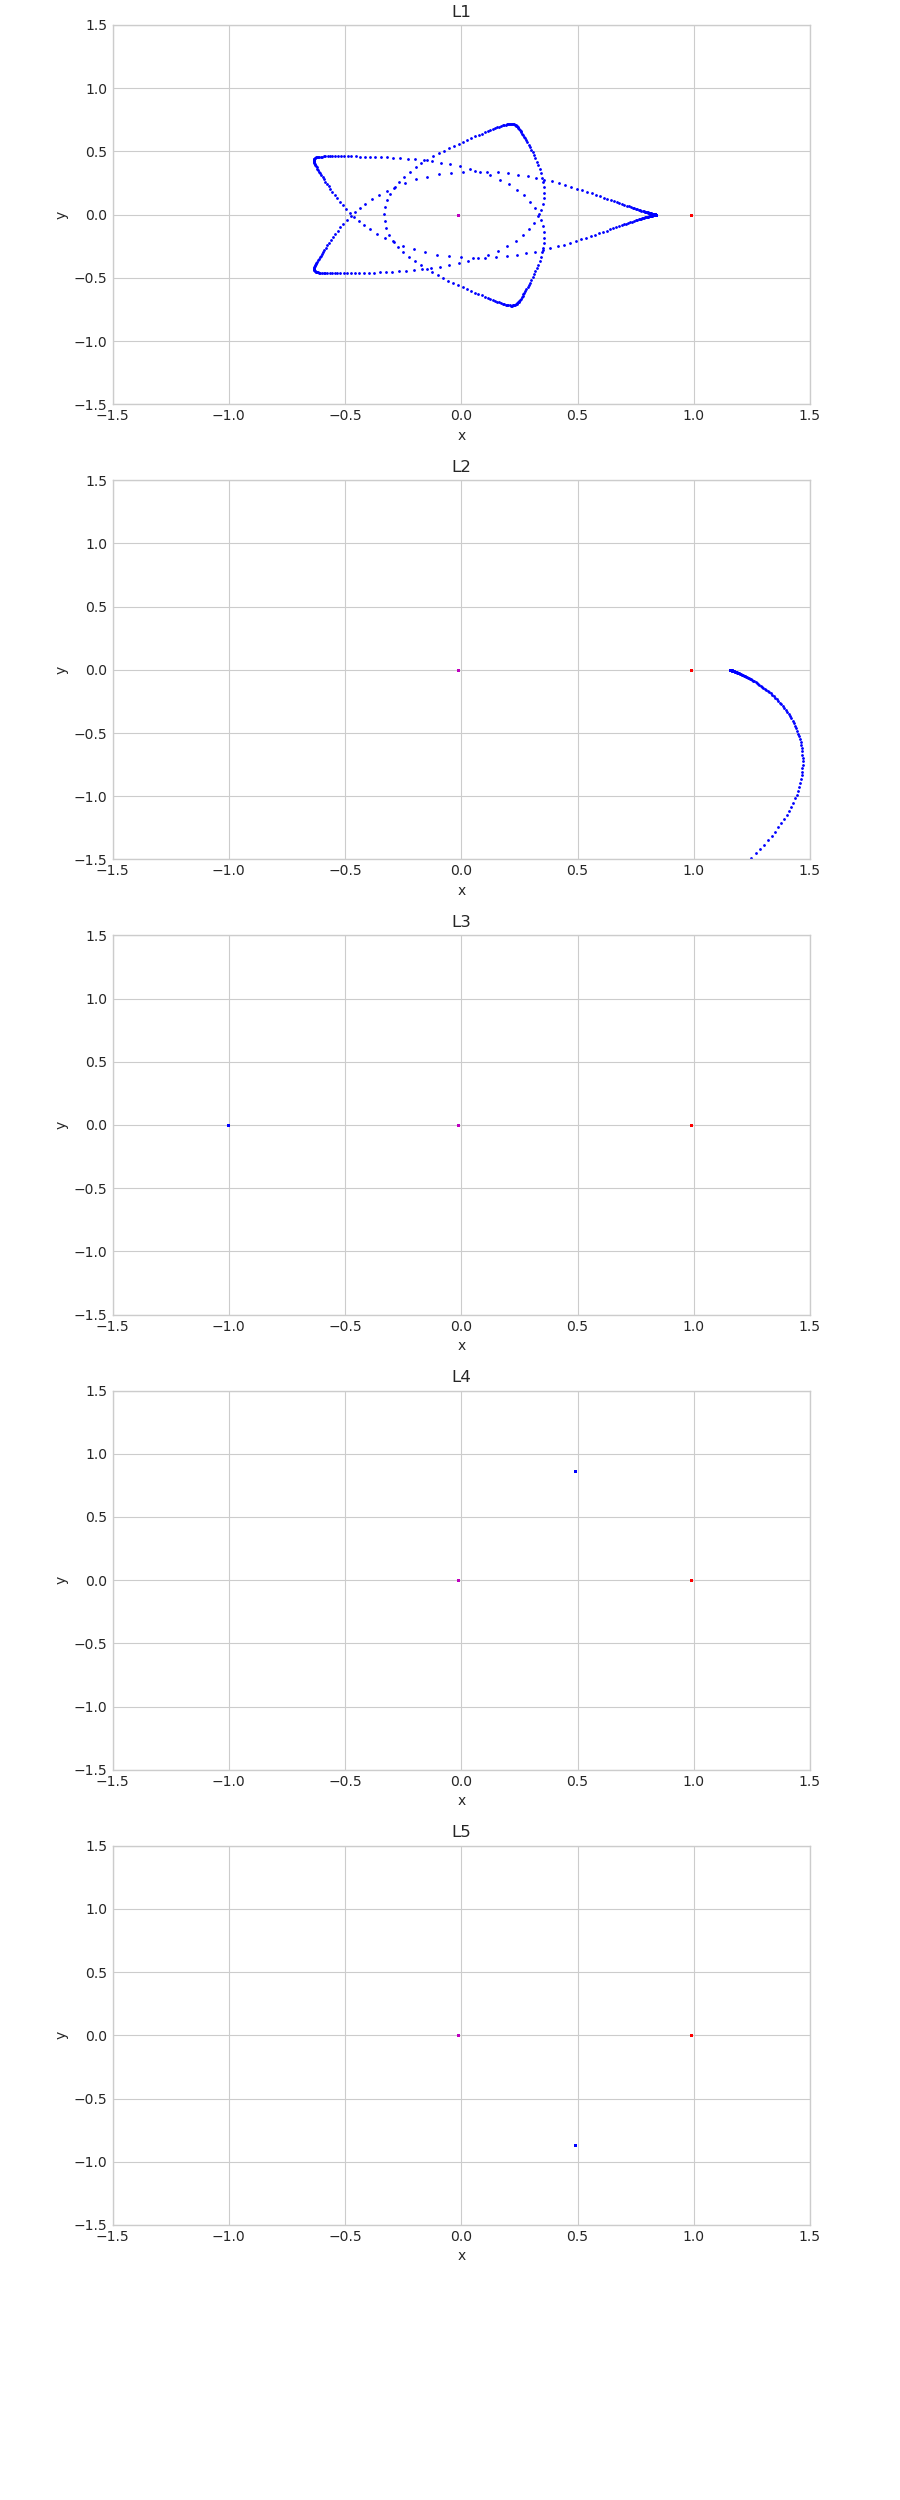

In [31]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=len(lagrange_st0),figsize=(9,5*5))
fig.subplots_adjust(hspace=0.2,top=0.99)
for idx in range(len(lagrange_st0)):
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel('y')
    limit=1.5
    x_limits = (-limit,limit)
    y_limits = (-limit,limit)
    ax[idx].set_xlim(x_limits)
    ax[idx].set_ylim(y_limits)
    ax[idx].plot(r1_xyz_ts[:,0:1], r1_xyz_ts[:,1:2] ,  'mo', ms = 1 )
    ax[idx].plot(r2_xyz_ts[:,0:1], r2_xyz_ts[:,1:2] ,  'ro', ms = 1 )
    ax[idx].plot(sols[idx].y[0:1,:].T, sols[idx].y[1:2,:].T,'bo', ms=1)
    ax[idx].set_title("L"+str(idx+1))  

### Rotating reference frame (dimensional)

In [61]:
print (W)

2.6616995389416534e-06


In [44]:
lagrange_st0 =[np.concatenate((L, np.zeros(3))) for L in dlag_points]
R = EARTH_MOON['l_star'] # km
X1 = -(R*EARTH_MOON['m2']/(EARTH_MOON['m1']+EARTH_MOON['m2']))
X2 = R*EARTH_MOON['m1']/(EARTH_MOON['m1']+EARTH_MOON['m2'])
G = 6.6742e-20 # Km^3/Kg*s^2
m1 = EARTH_MOON['m1']
alpha = EARTH_MOON['alpha']
MOON_ROTATION_PERIOD_IN_SECS=27*24*3600+7*3600+43*60+11.5
W = 2*np.pi/MOON_ROTATION_PERIOD_IN_SECS # rad/sec
t0 = 0
tf = MOON_ROTATION_PERIOD_IN_SECS*0.5
t_eval = None
sols = []
for idx, S0 in enumerate(lagrange_st0):
    sols.append(solve_ivp(dSdt_dimensional, (t0, tf), S0, args=(W, G, alpha, m1, X1, X2), method='BDF', rtol= 1e-5, t_eval=t_eval, dense_output=False))
    print (len(sols[idx].t))

99
159
44
18
17


<IPython.core.display.Javascript object>


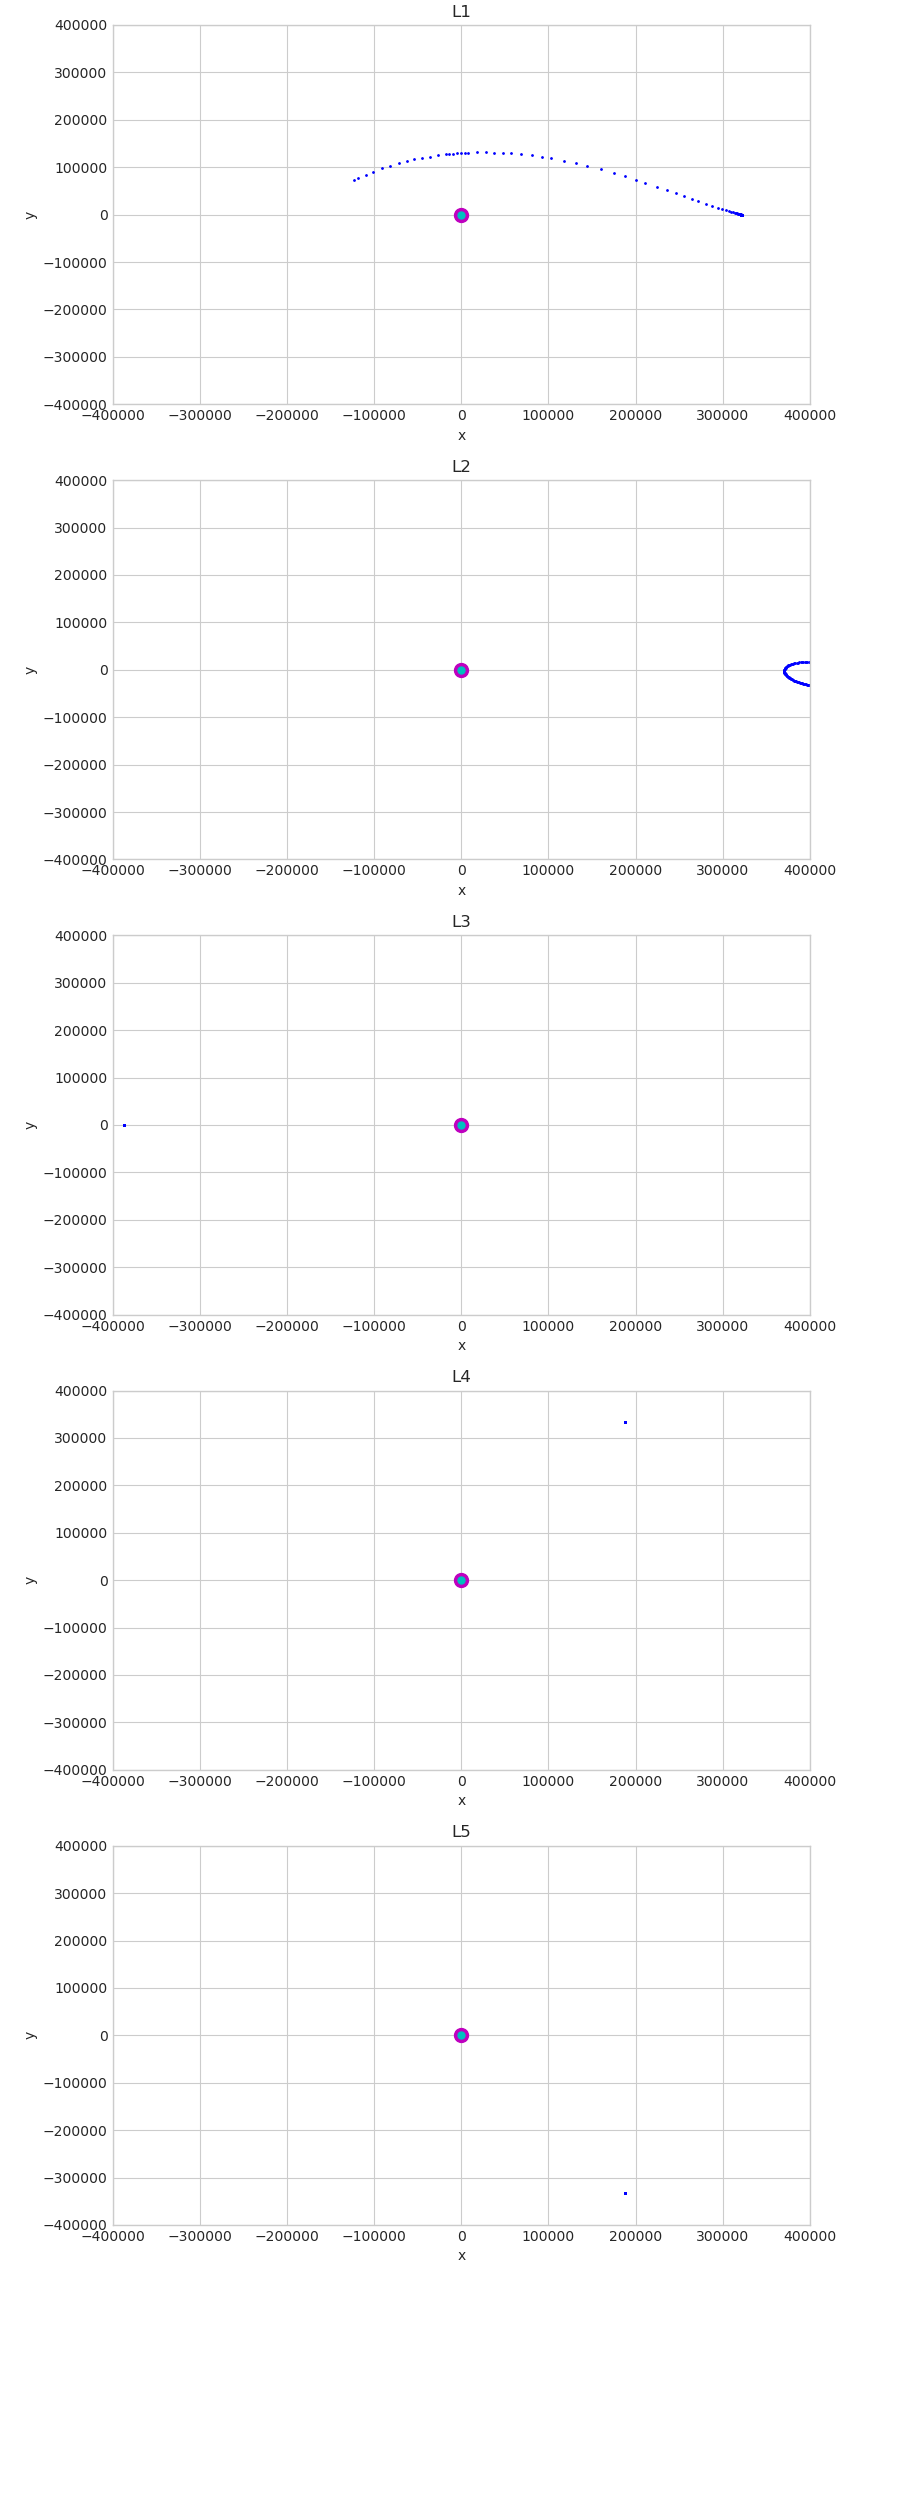

In [385]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=len(lagrange_st0),figsize=(9,5*5))
fig.subplots_adjust(hspace=0.2,top=0.99)
for idx in range(len(lagrange_st0)):
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel('y')
    limit=400000
    x_limits = (-limit,limit)
    y_limits = (-limit,limit)
    #x_limits = (1,1.2)
    #y_limits = (-0.1,0.1)    
    ax[idx].set_xlim(x_limits)
    ax[idx].set_ylim(y_limits)
    ax[idx].plot(-alpha ,    0, 'mo', ms = 10 )
    ax[idx].plot( 1 - alpha, 0, 'co', ms = 5  )
    ax[idx].plot(sols[idx].y[0:1,:].T, sols[idx].y[1:2,:].T,'bo', ms=1)
    ax[idx].set_title("L"+str(idx+1))  

In [ ]:
# There is a paper where several examples of restricted three-body test problems are shown
# The name of the paper is "A collection of restricted three-body test problems"
# https://jfuchs.hotell.kau.se/kurs/amek/prst/04_3bdy.pdf

1 0.994000e+00 -0.21138987966945026683e+01 0.54367954392601899690e+01 865
2 0.994000e+00 -0.20317326295573368357e+01 0.11124340337266085135e+02 961
3 0.994000e+00 -0.20015851063790825224e+01 0.17065216560157962559e+02 1071
4 0.997000e+00 -0.16251217072210773125e+01 0.22929723423442969481e+02 1067
5 0.879962e+00 -0.66647197988564140807e+00 0.63006757422352314657e+01 1198
6 0.879962e+00 -0.43965281709207999128e+00 0.12729711861022426544e+02 1358
7 0.879962e+00 -0.38089067106386964470e+00 0.19138746281183026809e+02 1682
8 0.997000e+00 -0.18445010489730401177e+01 0.12353901248612092736e+02 2139
9 0.100000e+01 -0.16018768253456252603e+01 0.12294387796695023304e+02 1880
10 0.100300e+01 -0.14465123738451062297e+01 0.12267904265603897140e+02 1769
11 0.120000e+01 -0.71407169828407848921e+00 0.18337451820715063383e+02 1039
12 0.120000e+01 -0.67985320356540547720e+00 0.30753758552146029263e+02 1501
13 0.120000e+01 -0.67153130632829144331e+00 0.43214375227857454128e+02 1991
14 0.120000e+01 -0.66998291305226832207e+00 0.55672334134347612727e+02 2494
15 0.120000e+01 -0.66975741517271092087e+00 0.68127906604713772763e+02 2999
16 -0.102745e+01 0.40334488290490413053e-01 0.18371316400018903965e+03 2422
17 -0.976680e+00 -0.61191623926410837000e-01 0.17733241131524483004e+03 3334
18 -0.766650e+00 -0.51230158665978820282e+00 0.17660722897242937108e+03 5238
19 -0.109137e+01 0.14301959822238380020e+00 0.82949461922342093092e+02 1659
20 -0.110137e+01 0.15354250908611454510e+00 0.60952121909407746612e+02 1384

In [45]:
st0 = [
    np.array([0.994000e+00,0,0,0, -0.21138987966945026683e+01 ,0]),
    np.array([0.994000e+00,0,0,0, -0.20317326295573368357e+01 ,0]),
    np.array([0.994000e+00,0,0,0, -0.20015851063790825224e+01 ,0]),
    np.array([0.997000e+00 ,0,0,0,-0.16251217072210773125e+01 ,0]),
    np.array([0.879962e+00,0,0,0, -0.66647197988564140807e+00,0]),
    np.array([0.879962e+00 ,0,0,0,-0.43965281709207999128e+00 ,0]),
    np.array([0.879962e+00,0,0,0, -0.38089067106386964470e+00,0]),
    np.array([0.997000e+00 ,0,0,0,-0.18445010489730401177e+01 ,0]),
    np.array([0.100000e+01,0,0,0, -0.16018768253456252603e+01,0]),
    np.array([0.100300e+01,0,0,0, -0.14465123738451062297e+01 ,0]),
    np.array([0.120000e+01,0,0,0, -0.71407169828407848921e+00 ,0]),
    np.array([0.120000e+01,0,0,0, -0.67985320356540547720e+00 ,0]),
    np.array([0.120000e+01,0,0,0, -0.67153130632829144331e+00 ,0]),
    np.array([0.120000e+01,0,0,0, -0.66998291305226832207e+00 ,0]),
    np.array([0.120000e+01,0,0,0, -0.66975741517271092087e+00 ,0])
]

tspans = [ 0.54367954392601899690e+01,
           0.11124340337266085135e+02,
           0.17065216560157962559e+02,
           0.22929723423442969481e+02,
           0.63006757422352314657e+01,
           0.12729711861022426544e+02,
           0.19138746281183026809e+02,
           0.12353901248612092736e+02,
           0.12294387796695023304e+02,
           0.12267904265603897140e+02,
           0.18337451820715063383e+02,
           0.30753758552146029263e+02,
           0.43214375227857454128e+02,
           0.55672334134347612727e+02,
           0.68127906604713772763e+02]

alpha = 0.012277471
t_eval = None
sols = propagate_orbit(0, alpha, st0, tspans, dSdt, t_eval)

365
394
425
407
512
537
619
966
785
747
403
508
677
844
1011


<IPython.core.display.Javascript object>


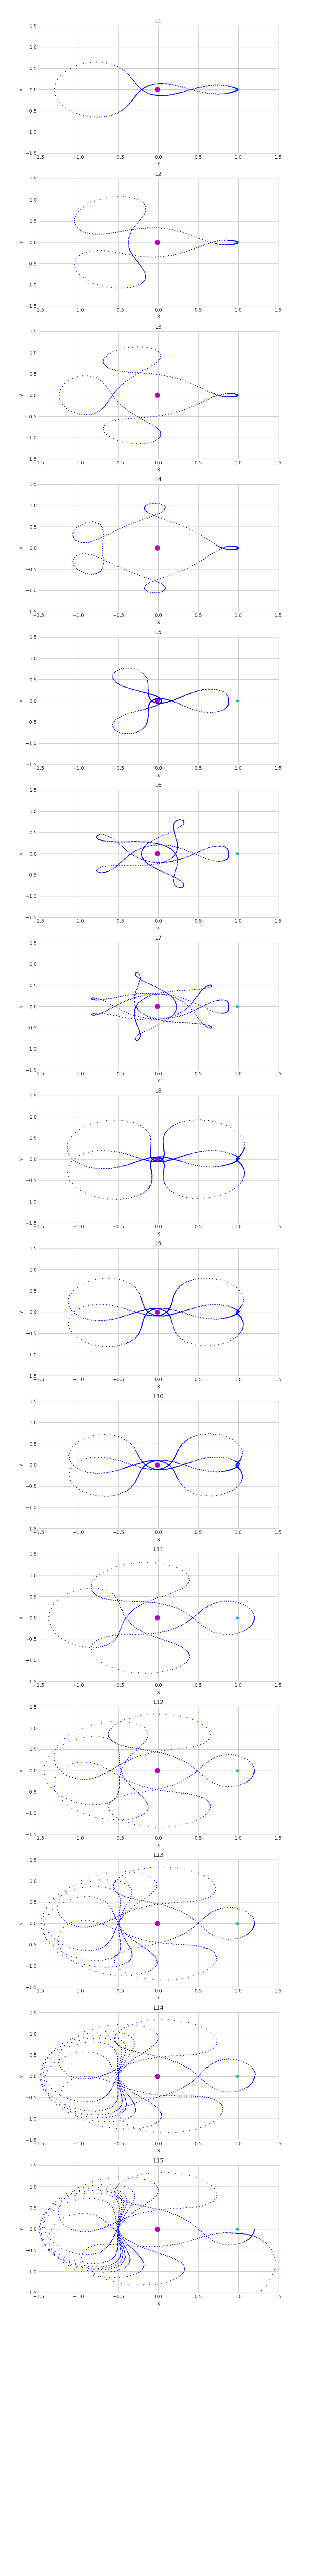

In [46]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=len(st0),figsize=(9,5*15))
fig.subplots_adjust(hspace=0.2,top=0.99)
for idx in range(len(st0)):
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel('y')
    limit=1.5
    x_limits = (-limit,limit)
    y_limits = (-limit,limit)
    #x_limits = (1,1.2)
    #y_limits = (-0.1,0.1)    
    ax[idx].set_xlim(x_limits)
    ax[idx].set_ylim(y_limits)
    ax[idx].plot(-alpha ,    0, 'mo', ms = 10 )
    ax[idx].plot( 1 - alpha, 0, 'co', ms = 5  )
    ax[idx].plot(sols[idx].y[0:1,:].T, sols[idx].y[1:2,:].T,'bo', ms=1)
    ax[idx].set_title("L"+str(idx+1))  

In [19]:
#https://numpy.org/doc/stable/reference/generated/numpy.arange.html#numpy.arange
lagrange_st0 =[np.concatenate((L, np.zeros(3))) for L in lag_points]
alpha = EARTH_MOON['alpha']
# With n_periods=3, the lagrange points are stable. However, with more simulation time, L1, L2 and L3 starts to diverge.
# L4 and L5 are more stable.
n_periods = 10
tspans = [ n_periods*2*np.pi] * len(lagrange_st0)
t_eval = np.arange(0, n_periods*2*np.pi, one_day)
#t_eval = None
sols = propagate_orbit(0, alpha, lagrange_st0, tspans, dSdt, t_eval,method='LSODA')

NameError: name 'one_day' is not defined

In [33]:
def un_rotate(xy_rot, ts, w=1):
    xy = np.zeros(xy_rot.shape)
    xy[:,0] = np.multiply(xy_rot[:,0],np.cos(ts)) - np.multiply(xy_rot[:,1], np.sin(ts))
    xy[:,1] = np.multiply(xy_rot[:,0],np.sin(ts)) + np.multiply(xy_rot[:,1], np.cos(ts))
    return xy

In [18]:
# For calculating the inital velocity for the dimensional case
# I use this data above
W = 1
R = 1
w_xyz = np.array([0,0,W]) # The rotation velocity in the dimensional version in rad/sec
xyz = R*xy3[0,:] # The starting point of the m3
for idx in range(0,5):
    ts = sols[idx].t
    xy3 = un_rotate(sols[idx].y[0:2,:].T, ts)
    r = R*xy3[0,:] # r at t=0
    v = np.cross(w_xyz,xy3_at_t0)
    print (f'L{idx+1}: r: [{r[0]},{r[1]},{0}] v: [{v[0]},{v[1]},{v[2]}]')



NameError: name 'xy3' is not defined

In [69]:
# For L2, sols[1]
idx = 3
ts = sols[idx].t
xy1 = un_rotate(np.vstack([np.array([-alpha ,0])]*len(ts)),ts )
xy2 = un_rotate(np.vstack([np.array([1-alpha ,0])]*len(ts)),ts)
xy3 = un_rotate(sols[idx].y[0:2,:].T, ts)
xyMC= (m1*xy1+m2*xy2)/(m1+m2)

In [70]:
# Once we have the position vectors in the non-rotating frame of reference, we can calculate the velocity at any point becasue
# the v = w x r

In [71]:
W = 1
R = 1
w_xyz = np.array([0,0,W]) # The rotation velocity in the dimensional version in rad/sec
xyz = R*xy3[0,:] # The starting point of the m3
print(np.cross(w_xyz,xyz))

[-0.88608022  0.49914355  0.        ]


In [63]:
print (w_xyz)

[0.00000000e+00 0.00000000e+00 2.66169954e-06]


In [56]:
xy3

array([[ 1.15569399e+00,  0.00000000e+00],
       [ 1.12526808e+00,  2.63439440e-01],
       [ 1.03559240e+00,  5.13007763e-01],
       [ 8.91388732e-01,  7.35564218e-01],
       [ 7.00249954e-01,  9.19390337e-01],
       [ 4.72240274e-01,  1.05480696e+00],
       [ 2.19365295e-01,  1.13468386e+00],
       [-4.50601259e-02,  1.15481521e+00],
       [-3.07112955e-01,  1.11414102e+00],
       [-5.52995084e-01,  1.01480295e+00],
       [-7.69759857e-01,  8.62031526e-01],
       [-9.45993759e-01,  6.63870768e-01],
       [-1.07241739e+00,  4.30754615e-01],
       [-1.14237404e+00,  1.74957544e-01],
       [-1.15218023e+00, -9.00517256e-02],
       [-1.10131961e+00, -3.50319420e-01],
       [-9.92470212e-01, -5.92141425e-01],
       [-8.31363368e-01, -8.02784866e-01],
       [-6.26481987e-01, -9.71158540e-01],
       [-3.88613876e-01, -1.08839692e+00],
       [-1.30283724e-01, -1.14832693e+00],
       [ 1.34906377e-01, -1.14779304e+00],
       [ 3.92993129e-01, -1.08682335e+00],
       [ 6.

In [365]:
xy1 = xy1 - xyMC
xy2 = xy2 - xyMC

<IPython.core.display.Javascript object>


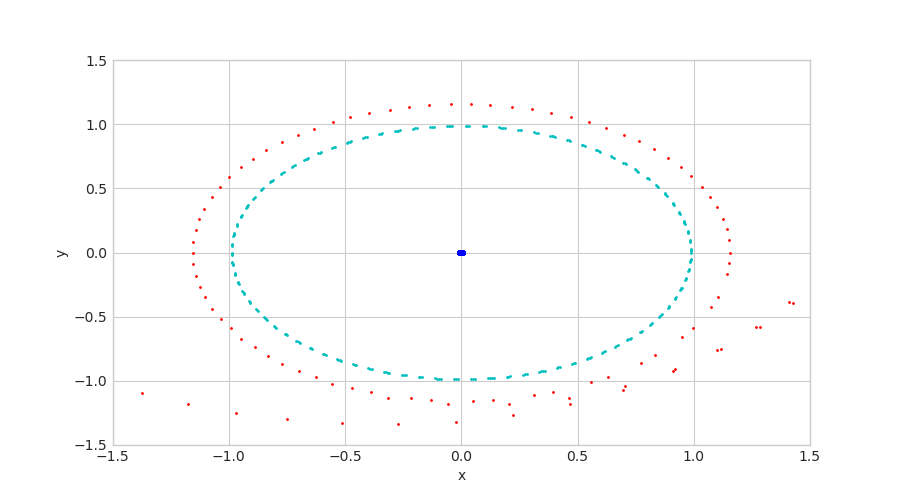

In [366]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=1,figsize=(9,5))
ax.set_xlabel('x')
ax.set_ylabel('y')
limit=1.5
x_limits = (-limit,limit)
y_limits = (-limit,limit)
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
#ax.plot(-alpha ,    0, 'mo', ms = 10 )
#ax.plot( 1 - alpha, 0, 'co', ms = 5  )
#ax.plot(orbs['m1'][:,0], orbs['m1'][:,1],'bo', ms=1)
#ax.plot(orbs['m2'][:,0], orbs['m2'][:,1],'co', ms=1)
#ax.plot(orbs['m3'][:,0], orbs['m3'][:,1],'ro', ms=1)
ax.plot(xy1[:,0], xy1[:,1],'bo', ms=1)
ax.plot(xy2[:,0], xy2[:,1],'co', ms=1)
ax.plot(xy3[:,0], xy3[:,1],'ro', ms=1)

In [120]:
A = np.array([[1,2],[0,1]])

In [131]:
B = np.array([[10,48],[0,10]])

In [132]:
np.dot(A,B)

array([[10, 68],
       [ 0, 10]])

In [133]:
np.dot(B,A)

array([[10, 68],
       [ 0, 10]])